# Visualization of evaluation results

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")
from bitcoin_rpc import *

## Parameter

In [2]:

############## Evaluation Parameters

# number of kafka partitions 
kafka_partitions_list = [1,2,4,8]

# batch processing
#batching_list = [1, 100, 400, 800]
batching_list = [0, 1, 10, 100]

# neo4j heap size
heap_size_list = [5, 8, 16]

# matching input on previous address
match_on_previous_add = True  #(?) => previous address is matched in the script (bitcoind)

# bypass kafka pipeline
bypass_kafka = False 



############## Default testing parameter values

default_kafka_partitions = kafka_partitions_list[0]
default_batching_size = batching_list[0]
default_heap_size = heap_size_list[0]
default_match_on_previous_add = True
default_bypass_kafka = False

default_values = {
    'default_kafka_partitions'      : kafka_partitions_list[0],
    'default_batching_size'         : batching_list[0],
    'default_heap_size'             : heap_size_list[0],
    'default_match_on_previous_add' : True,
    'default_bypass_kafka'          : False
}

In [3]:
### 
#evaluation parameter

# avg or median: 
#result_parameter = 'median'
result_parameter = 'avg'

# figures
dpi = 600


# resutls file
path = 'evaluation_results.csv'

## Data preprocessing
- Reading data in
- creating filtered dataset
    - exlcuding minima and maxima
    - taking average of remaining results per configuration settings

In [4]:
# read in data
results_dir_path = './results/'
df_raw = pd.read_csv(results_dir_path + path)

print('Shape of dataset: ', df_raw.shape)
print('Tail of dataset:')
df_raw.tail()

Shape of dataset:  (110, 15)
Tail of dataset:


,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,check_correctness,endTimePart1,endTimePart2,totalExecutionTime,timeOutReached
105,11,1,True,591116,591126,1,0,True,5,True,False,1450.127351,1449.570284,1450.140657,False
106,11,2,True,591116,591126,1,0,True,5,True,False,1488.323904,1487.768551,1488.334029,False
107,11,3,True,591116,591126,1,0,True,5,True,False,1485.924974,1485.376107,1485.939650,False
108,11,4,True,591116,591126,1,0,True,5,True,False,1476.137909,1475.583509,1476.162308,False
109,11,5,True,591116,591126,1,0,True,5,True,False,1454.057979,1453.498149,1454.069239,False


In [5]:
df_raw.columns

Index(['experimentRun', 'subRun', 'evaluate_original', 'start_block_height',
       'end_block_height', 'kafka_partitions', 'batching',
       'match_on_previous_add', 'heap_size', 'bypass_kafka',
       'check_correctness', 'endTimePart1', 'endTimePart2',
       'totalExecutionTime', 'timeOutReached'],
      dtype='object')

In [6]:
# create new empty dataframe for filtered values
df = pd.DataFrame(columns=df_raw.columns)

# list of parameters to evaluate on
parameter = ['kafka_partitions', 
             'batching',
             'match_on_previous_add',
             'heap_size', 
             'bypass_kafka']

# nr. of different runs
numberOfRuns    = len(df_raw['experimentRun'].unique())
numberOfSubRuns = len(df_raw['subRun'].unique())

for evaluateOriginal in True,False:

    df_half = df_raw[df_raw['evaluate_original'] == evaluateOriginal]
    
    # filter out maxima
    for experimentRun in range(numberOfRuns):

        experimentRun += 1
        
        if df_half[df_half['experimentRun']==experimentRun].shape[0] > 0:

            
            if result_parameter == 'avg':
                # find minimum and maximum of total execution time
                maximum = max(df_half['totalExecutionTime'][df_half['experimentRun']==experimentRun])
                minimum = min(df_half['totalExecutionTime'][df_half['experimentRun']==experimentRun])


                # exclude min and max if more than three reruns are recorded
                if df_half[(df_half['experimentRun']==experimentRun)].shape[0] >= 3:
                    df_filtered_run = df_half[(df_half['experimentRun']==experimentRun) & (df_half['totalExecutionTime']!=maximum) & (df_half['totalExecutionTime']!=minimum)]
                #exclude max if only two runs recorded
                elif df_half[(df_half['experimentRun']==experimentRun)].shape[0] == 2:
                    df_filtered_run = df_half[(df_half['experimentRun']==experimentRun) & (df_half['totalExecutionTime']!=minimum)]
                else:
                    df_filtered_run = df_half[(df_half['experimentRun']==experimentRun)]

                # create final entry by averaging over remaining measures
                filtered_entry                       = pd.DataFrame(df_filtered_run.iloc[0,:].copy()).T
                filtered_entry['subRun']             = result_parameter
                filtered_entry['endTimePart1']       = df_filtered_run['endTimePart1'].mean()
                filtered_entry['endTimePart2']       = df_filtered_run['endTimePart2'].mean()
                filtered_entry['totalExecutionTime'] = df_filtered_run['totalExecutionTime'].mean()

                
            elif result_parameter == 'median':
                
                median_execution_time = np.median(df_half['totalExecutionTime'][df_half['experimentRun']==experimentRun])
                
                df_filtered_run = df_half[(df_half['experimentRun']==experimentRun) & (df_half['totalExecutionTime']==median_execution_time)]
            
                filtered_entry                       = pd.DataFrame(df_filtered_run.iloc[0,:].copy()).T
                filtered_entry['subRun']             = result_parameter
                filtered_entry['endTimePart1']       = df_filtered_run['endTimePart1']
                filtered_entry['endTimePart2']       = df_filtered_run['endTimePart2']
                filtered_entry['totalExecutionTime'] = df_filtered_run['totalExecutionTime']
                
            else:
                print('result_parameter not set!')
                break


            df=pd.concat([df,filtered_entry], ignore_index=True)

# final filtered dataset
display(df)

,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,check_correctness,endTimePart1,endTimePart2,totalExecutionTime,timeOutReached
0,1,avg,True,591116,591126,1,0,True,5,False,False,1221.994611,1221.344061,1222.015466,False
1,2,avg,True,591116,591126,2,0,True,5,False,False,1193.417364,1192.784915,1193.441807,False
2,3,avg,True,591116,591126,4,0,True,5,False,False,1166.696657,1166.054086,1166.717172,False
3,4,avg,True,591116,591126,8,0,True,5,False,False,1151.682487,1151.048046,1151.704431,False
4,5,avg,True,591116,591126,1,1,True,5,False,False,1147.566178,1146.900729,1147.588092,False
5,6,avg,True,591116,591126,1,10,True,5,False,False,1162.682474,1162.823430,1163.714376,False
6,7,avg,True,591116,591126,1,100,True,5,False,False,1153.536924,1160.004021,1163.592715,False
7,8,avg,True,591116,591126,1,0,True,8,False,False,1174.648866,1174.003245,1174.670979,False
8,9,avg,True,591116,591126,1,0,True,16,False,False,1162.846932,1162.206995,1162.866309,False
9,10,avg,True,591116,591126,1,0,False,5,False,False,270.174704,269.538410,270.194322,False


In [7]:
experimentRun = 1
df_half = df_raw[(df_raw['experimentRun']==1) & (df_raw['evaluate_original']==True)]

median_execution_time = np.median(df_half['totalExecutionTime'][df_half['experimentRun']==experimentRun])
                
df_filtered_run = df_half[(df_half['experimentRun']==experimentRun) & (df_half['totalExecutionTime']==median_execution_time)]

'''
filtered_entry                       = pd.DataFrame(df_filtered_run.iloc[0,:].copy()).T
filtered_entry['subRun']             = result_parameter
filtered_entry['endTimePart1']       = df_filtered_run['endTimePart1']
filtered_entry['endTimePart2']       = df_filtered_run['endTimePart2']
filtered_entry['totalExecutionTime'] = df_filtered_run['totalExecutionTime']
'''
df_filtered_run



,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,check_correctness,endTimePart1,endTimePart2,totalExecutionTime,timeOutReached
57,1,3,True,591116,591126,1,0,True,5,False,False,1204.754154,1204.069633,1204.776429,False


In [8]:
df_half['totalExecutionTime'][df_half['experimentRun']==experimentRun]
print(np.median(df_half['totalExecutionTime'][df_half['experimentRun']==experimentRun]))
df_half[df_half['experimentRun']==experimentRun]

1204.776428937912


,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,check_correctness,endTimePart1,endTimePart2,totalExecutionTime,timeOutReached
55,1,1,True,591116,591126,1,0,True,5,False,False,1767.215572,1766.537651,1767.245919,False
56,1,2,True,591116,591126,1,0,True,5,False,False,1264.538065,1263.919008,1264.558252,False
57,1,3,True,591116,591126,1,0,True,5,False,False,1204.754154,1204.069633,1204.776429,False
58,1,4,True,591116,591126,1,0,True,5,False,False,1196.691614,1196.043540,1196.711715,False
59,1,5,True,591116,591126,1,0,True,5,False,False,1190.151779,1189.483599,1190.170984,False


In [9]:
display(df)

,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,check_correctness,endTimePart1,endTimePart2,totalExecutionTime,timeOutReached
0,1,avg,True,591116,591126,1,0,True,5,False,False,1221.994611,1221.344061,1222.015466,False
1,2,avg,True,591116,591126,2,0,True,5,False,False,1193.417364,1192.784915,1193.441807,False
2,3,avg,True,591116,591126,4,0,True,5,False,False,1166.696657,1166.054086,1166.717172,False
3,4,avg,True,591116,591126,8,0,True,5,False,False,1151.682487,1151.048046,1151.704431,False
4,5,avg,True,591116,591126,1,1,True,5,False,False,1147.566178,1146.900729,1147.588092,False
5,6,avg,True,591116,591126,1,10,True,5,False,False,1162.682474,1162.823430,1163.714376,False
6,7,avg,True,591116,591126,1,100,True,5,False,False,1153.536924,1160.004021,1163.592715,False
7,8,avg,True,591116,591126,1,0,True,8,False,False,1174.648866,1174.003245,1174.670979,False
8,9,avg,True,591116,591126,1,0,True,16,False,False,1162.846932,1162.206995,1162.866309,False
9,10,avg,True,591116,591126,1,0,False,5,False,False,270.174704,269.538410,270.194322,False


In [10]:
# add total execution time per block
df['nrOfBlocks']                = df.apply(lambda x: (x.end_block_height-x.start_block_height), axis = 1)
df['totalExecutionTime_pB_sec'] = df.apply(lambda x: np.round( (x.totalExecutionTime/x.nrOfBlocks ), 3), axis = 1 ) 


def assignTestParameter(partitions, batching, matchOnPrevious, heapSize, bypass_kafka):

    testParameter = ''
    if (partitions       == default_values['default_kafka_partitions']) and \
        (batching        == default_values['default_batching_size'])    and \
        (matchOnPrevious == default_values['default_match_on_previous_add']) and \
        (heapSize        == default_values['default_heap_size']) and \
        (bypass_kafka    == default_values['default_bypass_kafka']):
        testParameter = 'Default'
    elif partitions      != default_values['default_kafka_partitions']:
        testParameter = 'Partitions'
    elif batching        != default_values['default_batching_size']:
        testParameter = 'Batching'
    elif matchOnPrevious != default_values['default_match_on_previous_add']:
        testParameter = 'Match on previous transaction'
    elif heapSize        != default_values['default_heap_size']:
        testParameter = 'Heap size'
    elif bypass_kafka    != default_values['default_bypass_kafka']:
        testParameter = 'Bypass Kafka'
    return testParameter
    

#df = df[(df[testParam]==x)&(df['kafka_partitions']==default_kafka_partitions)&(df['heap_size']==default_heap_size)&(df['bypass_kafka']==default_bypass_kafka)][resultColumn]
df['test_parameter'] = df.apply(lambda x: assignTestParameter(x.kafka_partitions, x.batching, x.match_on_previous_add, x.heap_size, x.bypass_kafka) , axis=1)

### Retrieval of transactions

In [11]:
df['nr_of_Transactions'] = 0
df['nr_of_RPCcalls'] = 0
df['pushedObjects'] = 0


for evaluateOriginal in True,False:
    
    df_half = df[df['evaluate_original'] == evaluateOriginal]
    if df_half.shape[0] > 0:
        startBlock = df_half['start_block_height'].unique()[0]
        endBlock   = df_half['end_block_height'].unique()[0]

        transactionCounts = []
        nrOfTransactions  = 0
        nrOfRPCcalls      = 0
        nrOfInputRPCcalls = 0
        addressesToMatch  = 0

        # saved results for used ranges
        if startBlock == 1 and endBlock == 10001:
            nrOfTransactions  = 10092
            nrOfRPCcalls      = 30717
            nrOfInputRPCcalls = 625
            addressesToMatch  = 21250
        elif startBlock == 591116 and endBlock == 591126:
            nrOfTransactions  = 20603 
            nrOfRPCcalls      = 80088
            nrOfInputRPCcalls = 59465
            addressesToMatch  = 118950

        else:
            for blockHeight in np.arange(startBlock, endBlock, 1):

                blockhash    = getBlockHash(blockHeight)
                data, block  = getblock(blockhash)
                nrOfRPCcalls += 2
                transactionCounts.append(block['nTx'])
                
                # get nrOfInputRPCcalls & addressesToMatch
                # only for non-coinbase txs
                for tx_position in range(len(block['tx'])):
                    tx = block['tx'][tx_position]

                    # get tx info
                    txdata = gettx(tx,block,True)
                    nrOfRPCcalls += 1

                    nrOfInputs = len(txdata['input_list'])
                    nrOfOutputs = len(txdata['output_list'])

                    addressesToMatch += nrOfInputs
                    addressesToMatch += nrOfInputs

                    # only applies to non rpc calls
                    if tx_position != 0:
                        nrOfInputRPCcalls += nrOfInputs

            nrOfTransactions = sum(transactionCounts)
            nrOfRPCcalls += nrOfInputRPCcalls

        print('\nEvaluateOriginal: ', evaluateOriginal)
        print('Transaction count: ', nrOfTransactions)
        print('Nr. of input RPC calls: ', nrOfInputRPCcalls)
        print('Nr. of RPC calls total: ', nrOfRPCcalls)
        print('Addresses to match count: ', addressesToMatch)


        #df[df['evaluate_original'] == evaluateOriginal]['nr_of_Transactions'] = nrOfTransactions
        df.loc[df['evaluate_original'] == evaluateOriginal, 'nr_of_Transactions'] = nrOfTransactions
        df.loc[df['evaluate_original'] == evaluateOriginal, 'nr_of_RPCcalls'] = nrOfRPCcalls
        df.loc[df['evaluate_original'] == evaluateOriginal, 'pushedObjects'] = (endBlock-startBlock)+nrOfTransactions
        
    
#create totalExecutionTime per Transaction in seconds
df['totalExecutionTime_pT_sec'] = df.apply(lambda x: np.round( (x.totalExecutionTime/x.nr_of_Transactions ), 4), axis = 1 ) 

# creating of milisecond result column
df['totalExecutionTime_pT_milsec'] = df['totalExecutionTime_pT_sec'].apply(lambda x: x*1000)

df['totalExecutionTime_pRPC_milsec'] = df.apply(lambda x: np.round( (x.totalExecutionTime/x.nr_of_RPCcalls*1000), 1), axis = 1 )

df['totalExecutionTime_pObject_milsec'] = df.apply(lambda x: np.round( (x.totalExecutionTime/x.pushedObjects*1000), 1), axis = 1 )

df



EvaluateOriginal:  True
Transaction count:  20603
Nr. of input RPC calls:  59465
Nr. of RPC calls total:  80088
Addresses to match count:  118950

EvaluateOriginal:  False
Transaction count:  10092
Nr. of input RPC calls:  625
Nr. of RPC calls total:  30717
Addresses to match count:  21250


,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,...,nrOfBlocks,totalExecutionTime_pB_sec,test_parameter,nr_of_Transactions,nr_of_RPCcalls,pushedObjects,totalExecutionTime_pT_sec,totalExecutionTime_pT_milsec,totalExecutionTime_pRPC_milsec,totalExecutionTime_pObject_milsec
0,1,avg,True,591116,591126,1,0,True,5,False,...,10,122.202,Default,20603,80088,20613,0.0593,59.3,15.3,59.3
1,2,avg,True,591116,591126,2,0,True,5,False,...,10,119.344,Partitions,20603,80088,20613,0.0579,57.9,14.9,57.9
2,3,avg,True,591116,591126,4,0,True,5,False,...,10,116.672,Partitions,20603,80088,20613,0.0566,56.6,14.6,56.6
3,4,avg,True,591116,591126,8,0,True,5,False,...,10,115.170,Partitions,20603,80088,20613,0.0559,55.9,14.4,55.9
4,5,avg,True,591116,591126,1,1,True,5,False,...,10,114.759,Batching,20603,80088,20613,0.0557,55.7,14.3,55.7
5,6,avg,True,591116,591126,1,10,True,5,False,...,10,116.371,Batching,20603,80088,20613,0.0565,56.5,14.5,56.5
6,7,avg,True,591116,591126,1,100,True,5,False,...,10,116.359,Batching,20603,80088,20613,0.0565,56.5,14.5,56.4
7,8,avg,True,591116,591126,1,0,True,8,False,...,10,117.467,Heap size,20603,80088,20613,0.0570,57.0,14.7,57.0
8,9,avg,True,591116,591126,1,0,True,16,False,...,10,116.287,Heap size,20603,80088,20613,0.0564,56.4,14.5,56.4
9,10,avg,True,591116,591126,1,0,False,5,False,...,10,27.019,Match on previous transaction,20603,80088,20613,0.0131,13.1,3.4,13.1


## General statistics

In [12]:
for evaluateOriginal in True,False:
    df_half                      = df[df['evaluate_original'] == evaluateOriginal]
    if df_half.shape[0] > 0:
        minTotalExecutionTime        = np.round(min(df_half['totalExecutionTime']), 2)
        minTotalExecutionTime_pB_sec = np.round(min(df_half['totalExecutionTime_pB_sec']), 2)
        avgTransactionsPerBlock      = np.round(list(df_half['nr_of_Transactions']/df_half['nrOfBlocks'])[0], 1)
        minTotalExecutionTime_pT_sec = min(df_half['totalExecutionTime_pT_sec'])
        nrOfBlocks                   = df_half['nrOfBlocks'].unique()[0]

        print(f'''\n
    Evaluate Original: {evaluateOriginal}
    - Number of blocks: {nrOfBlocks}
    - Fastet total execution time:  {minTotalExecutionTime} sec
    - Avg execution time per block:  {minTotalExecutionTime} sec
    - Avg nr. of transactions per block: {avgTransactionsPerBlock}
    - Avgexecution time per transaction: {minTotalExecutionTime_pT_sec} sec
    - Run of minimum time:''')

        display(df_half[df_half['totalExecutionTime_pB_sec'] == min(df_half['totalExecutionTime_pB_sec'])] )



    Evaluate Original: True
    - Number of blocks: 10
    - Fastet total execution time:  270.19 sec
    - Avg execution time per block:  270.19 sec
    - Avg nr. of transactions per block: 2060.3
    - Avgexecution time per transaction: 0.0131 sec
    - Run of minimum time:


,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,...,nrOfBlocks,totalExecutionTime_pB_sec,test_parameter,nr_of_Transactions,nr_of_RPCcalls,pushedObjects,totalExecutionTime_pT_sec,totalExecutionTime_pT_milsec,totalExecutionTime_pRPC_milsec,totalExecutionTime_pObject_milsec
9,10,avg,True,591116,591126,1,0,False,5,False,...,10,27.019,Match on previous transaction,20603,80088,20613,0.0131,13.1,3.4,13.1




    Evaluate Original: False
    - Number of blocks: 10000
    - Fastet total execution time:  493.82 sec
    - Avg execution time per block:  493.82 sec
    - Avg nr. of transactions per block: 1.0
    - Avgexecution time per transaction: 0.0489 sec
    - Run of minimum time:


,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,...,nrOfBlocks,totalExecutionTime_pB_sec,test_parameter,nr_of_Transactions,nr_of_RPCcalls,pushedObjects,totalExecutionTime_pT_sec,totalExecutionTime_pT_milsec,totalExecutionTime_pRPC_milsec,totalExecutionTime_pObject_milsec
21,11,avg,False,1,10001,1,0,True,5,True,...,10000,0.049,Bypass Kafka,10092,30717,20092,0.0489,48.9,16.1,24.6


## Differences between parameter

In [13]:
#resultColumn = 'totalExecutionTime'
#resultColumn = 'totalExecutionTime_pT_sec'
#resultColumn = 'totalExecutionTime_pT_milsec'
#resultColumn = 'totalExecutionTime_pRPC_milsec'
resultColumn = 'totalExecutionTime_pObject_milsec'

In [14]:
def assignEvaluationLabel(evaluateOriginal):
    if evaluateOriginal == True:
        label = 'Original nodes'
    else:
        label = 'Test nodes'
    return label

In [15]:
'''barResults = {
    'labels' : [],
    'T1-Default' : [],
    'T2-Partitions' : [],
    'T3-Batching' : [],
    'T4-Heap size' : [],
    'T5-Bypass Kafka' : [],
    'T6-Match on previous transaction': []
}'''

barResults = {
    'labels' : [],
    'Default' : [],
    'Partitions' : [],
    'Batching' : [],
    'Heap size' : [],
    'Match on previous transaction': [],
    'Bypass Kafka' : []
}

for evaluateOriginal in True,False:
    df_half = df[df['evaluate_original'] == evaluateOriginal]
    if df_half.shape[0] > 0:

        label = assignEvaluationLabel(evaluateOriginal)
        barResults['labels'].append(label)


        # collect values for each of the data arrays
        testParameter = df['test_parameter'].unique()

        # collect values for each of the data arrays
        # Minimum value for each parameter testing is chosen
        for param in testParameter:

            df_param   = df_half[df_half['test_parameter'] == param]
            if df_param.shape[0] > 0:
                minOfParam = df_param[resultColumn][df_param[resultColumn] == min (df_param[resultColumn])].values[0] #! 
                #print(minOfParam,'\n')
                barResults[param].append(minOfParam)
            else:
                barResults[param].append(0)


barResults



{'labels': ['Original nodes', 'Test nodes'],
 'Default': [59.3, 70.4],
 'Partitions': [55.9, 69.7],
 'Batching': [55.7, 69.8],
 'Heap size': [56.4, 70.4],
 'Match on previous transaction': [13.1, 70.3],
 'Bypass Kafka': [71.4, 24.6]}

71.4


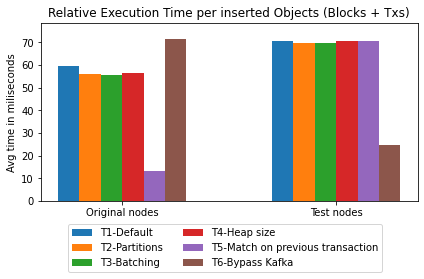

In [16]:
x = np.arange(len(barResults['labels']))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
positions = [-2.5,-1.5,-0.5,0.5,1.5,2.5]
c=0
max_x = 0
for param in barResults.keys():
    if param != 'labels':
        ax.bar(x + width*positions[c], np.array(barResults[param]), width, label= ('T' + str(c+1) + '-' +param))
        c+=1
        if np.max(np.array(barResults[param])) > max_x:
            max_x = np.max(np.array(barResults[param]))

print(max_x)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,max_x*1.1])
ax.set_ylabel( str(result_parameter).capitalize() + ' time in miliseconds')
ax.set_xticks(x)
ax.set_xticklabels(barResults['labels'])
ax.legend(bbox_to_anchor=(0.92, -0.1), ncol=2)
fig.tight_layout()
plt.savefig(results_dir_path + resultColumn + '_comparison_noHeader_' + result_parameter + '.png', dpi=dpi)

ax.set_title('Relative Execution Time per inserted Objects (Blocks + Txs)')
fig.tight_layout()

plt.savefig(results_dir_path + resultColumn + '_comparison_' + result_parameter + '.png', dpi=dpi)

plt.show()

## Total results

In [17]:
df_raw[df_raw['evaluate_original'] == True]

,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,check_correctness,endTimePart1,endTimePart2,totalExecutionTime,timeOutReached
55,1,1,True,591116,591126,1,0,True,5,False,False,1767.215572,1766.537651,1767.245919,False
56,1,2,True,591116,591126,1,0,True,5,False,False,1264.538065,1263.919008,1264.558252,False
57,1,3,True,591116,591126,1,0,True,5,False,False,1204.754154,1204.069633,1204.776429,False
58,1,4,True,591116,591126,1,0,True,5,False,False,1196.691614,1196.043540,1196.711715,False
59,1,5,True,591116,591126,1,0,True,5,False,False,1190.151779,1189.483599,1190.170984,False
60,2,1,True,591116,591126,2,0,True,5,False,False,1190.507072,1189.873533,1190.537610,False
61,2,2,True,591116,591126,2,0,True,5,False,False,1185.032730,1184.390440,1185.053147,False
62,2,3,True,591116,591126,2,0,True,5,False,False,1189.285431,1188.657520,1189.305860,False
63,2,4,True,591116,591126,2,0,True,5,False,False,1200.780746,1200.144225,1200.804548,False
64,2,5,True,591116,591126,2,0,True,5,False,False,1200.459590,1199.823692,1200.481951,False


In [18]:
df_raw[df_raw['evaluate_original'] == False]

,experimentRun,subRun,evaluate_original,start_block_height,end_block_height,kafka_partitions,batching,match_on_previous_add,heap_size,bypass_kafka,check_correctness,endTimePart1,endTimePart2,totalExecutionTime,timeOutReached
0,1,1,False,1,10001,1,0,True,5,False,False,1417.173064,1417.054848,1417.196833,False
1,1,2,False,1,10001,1,0,True,5,False,False,1407.963276,1407.853796,1407.978423,False
2,1,3,False,1,10001,1,0,True,5,False,False,1415.659207,1416.545244,1416.672559,False
3,1,4,False,1,10001,1,0,True,5,False,False,1415.834348,1416.720456,1416.848039,False
4,1,5,False,1,10001,1,0,True,5,False,False,1407.975436,1407.866120,1407.992085,False
5,2,1,False,1,10001,2,0,True,5,False,False,1400.684347,1401.570904,1401.697700,False
6,2,2,False,1,10001,2,0,True,5,False,False,1402.761693,1402.649397,1402.772271,False
7,2,3,False,1,10001,2,0,True,5,False,False,1398.032437,1397.921982,1398.048347,False
8,2,4,False,1,10001,2,0,True,5,False,False,1397.794757,1398.683183,1398.807259,False
9,2,5,False,1,10001,2,0,True,5,False,False,1399.337804,1400.220900,1400.350872,False


## Formatting table into Latex table

In [19]:
######## different last column : per Object


renamingDict = {
    'endTimePart1': 'Time part 1 (s)',
    'endTimePart2': 'Time part 2 (s)',
    'totalExecutionTime': 'Total time (s)',
#    'totalExecutionTime_pT_milsec': 'Total time per Transaction (ms)',
    'totalExecutionTime_pObject_milsec': 'Total time per object (ms)'
    
}

latex_table = ''
SecondRun = False

for evaluateOriginal in True,False:
    df_half = df[df['evaluate_original'] == evaluateOriginal].reset_index()

    evaluation_tasks = {
    'Tasks': ['T1', ' ', 'T2', ' ', ' ', 'T3', ' ',  'T4', ' ', 'T5','T6'],
    'Subtask': ['T1-1', 'T2-1', 'T2-2', 'T2-3', 'T3-1', 'T3-2', 'T3-3', 'T4-1', 'T4-2', 'T5-1', 'T6-1'],
    'Parameter': ['Default', ' ', 'Partitions', ' ', ' ', 'Batching', ' ', 'Heap size', ' ', 'Matching', 
                  'Bypass Kafka']
    }
    
    df_result_table = pd.DataFrame(evaluation_tasks)
    #df_result_table = pd.DataFrame()
    
    
    for columns in renamingDict.keys():
        df_result_table[renamingDict[columns]] = df_half[columns].apply(lambda x: np.round(x, 1))
    
    
    # parameter for table
    nrOfColumns = df_result_table.shape[0]
    label = assignEvaluationLabel(evaluateOriginal)
    
    # table headers
    if SecondRun == False:
        columnNames = list(df_result_table.columns)
        latex_table += ' & '
        for column in range(len(columnNames)):
            latex_table += columnNames[column] 
            if columnNames[column] != columnNames[-1]:
                latex_table += ' & '
            else:
                latex_table += ' \\\\ \n \\hline \n'
    SecondRun = True
    
    
    # table body
    latex_table += ' \n \\hline \n'
    
    latex_table += f'''\\multirow{{{nrOfColumns}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{\\textbf{{{label}}}}}}} \n'''

    Task = ''
    for row in range(df_result_table.shape[0]):
        currentTask = df_result_table.iloc[row,1][0:2]
        
        if currentTask != Task and row != 0:
            latex_table += f' \\cline{{2-{df_result_table.shape[1]+1}}} \n '
        Task = currentTask
        
        for column in range(df_result_table.shape[1]):
            latex_table += ' & '
            portential_value_to_append = df_result_table.iloc[row,column]
            if portential_value_to_append == 'T4':
                value_to_append = '\multirow{2}{*}{T4}'
            elif portential_value_to_append == 'Heap size':
                value_to_append = '\multirow{2}{*}{Heap size}'
            else:
                value_to_append = str(portential_value_to_append)
            latex_table += value_to_append
            #if column != range(df_result_table.shape[1])[-1]:
            #    latex_table += ' & '
        latex_table += ' \\\\ \n'
    latex_table += '\\hline \n'
        
    
    display(df_result_table)
print(latex_table)

,Tasks,Subtask,Parameter,Time part 1 (s),Time part 2 (s),Total time (s),Total time per object (ms)
0,T1,T1-1,Default,1222.0,1221.3,1222.0,59.3
1,,T2-1,,1193.4,1192.8,1193.4,57.9
2,T2,T2-2,Partitions,1166.7,1166.1,1166.7,56.6
3,,T2-3,,1151.7,1151.0,1151.7,55.9
4,,T3-1,,1147.6,1146.9,1147.6,55.7
5,T3,T3-2,Batching,1162.7,1162.8,1163.7,56.5
6,,T3-3,,1153.5,1160.0,1163.6,56.4
7,T4,T4-1,Heap size,1174.6,1174.0,1174.7,57.0
8,,T4-2,,1162.8,1162.2,1162.9,56.4
9,T5,T5-1,Matching,270.2,269.5,270.2,13.1


,Tasks,Subtask,Parameter,Time part 1 (s),Time part 2 (s),Total time (s),Total time per object (ms)
0,T1,T1-1,Default,1413.2,1413.7,1413.8,70.4
1,,T2-1,,1399.3,1400.2,1400.3,69.7
2,T2,T2-2,Partitions,1403.6,1404.4,1404.6,69.9
3,,T2-3,,1401.2,1401.4,1401.5,69.8
4,,T3-1,,1406.9,1407.8,1407.9,70.1
5,T3,T3-2,Batching,1400.8,1401.5,1401.8,69.8
6,,T3-3,,1405.8,1405.0,1410.2,70.2
7,T4,T4-1,Heap size,1413.6,1413.8,1413.9,70.4
8,,T4-2,,1420.7,1421.2,1421.4,70.7
9,T5,T5-1,Matching,1412.3,1412.6,1412.7,70.3


 & Tasks & Subtask & Parameter & Time part 1 (s) & Time part 2 (s) & Total time (s) & Total time per object (ms) \\ 
 \hline 
 
 \hline 
\multirow{11}{*}{\rotatebox[origin=c]{90}{\textbf{Original nodes}}} 
 & T1 & T1-1 & Default & 1222.0 & 1221.3 & 1222.0 & 59.3 \\ 
 \cline{2-8} 
  &   & T2-1 &   & 1193.4 & 1192.8 & 1193.4 & 57.9 \\ 
 & T2 & T2-2 & Partitions & 1166.7 & 1166.1 & 1166.7 & 56.6 \\ 
 &   & T2-3 &   & 1151.7 & 1151.0 & 1151.7 & 55.9 \\ 
 \cline{2-8} 
  &   & T3-1 &   & 1147.6 & 1146.9 & 1147.6 & 55.7 \\ 
 & T3 & T3-2 & Batching & 1162.7 & 1162.8 & 1163.7 & 56.5 \\ 
 &   & T3-3 &   & 1153.5 & 1160.0 & 1163.6 & 56.4 \\ 
 \cline{2-8} 
  & \multirow{2}{*}{T4} & T4-1 & \multirow{2}{*}{Heap size} & 1174.6 & 1174.0 & 1174.7 & 57.0 \\ 
 &   & T4-2 &   & 1162.8 & 1162.2 & 1162.9 & 56.4 \\ 
 \cline{2-8} 
  & T5 & T5-1 & Matching & 270.2 & 269.5 & 270.2 & 13.1 \\ 
 \cline{2-8} 
  & T6 & T6-1 & Bypass Kafka & 1472.0 & 1471.5 & 1472.1 & 71.4 \\ 
\hline 
 
 \hline 
\multirow{11}{*}{\rot